In [1]:
%pylab inline
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import matplotlib.ticker as mticker
from matplotlib.patches import Polygon
import cmocean.cm as cmo
import gsw

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

Populating the interactive namespace from numpy and matplotlib


In [2]:
savefig = True
figext = '.pdf'
datadir = '/Users/erik/Desktop/'

degsym = u'\u00B0'

def savefig(fignum, figext=figext, savefig=savefig):
    figname = 'Fig%s%s' % (fignum, figext)
    if savefig:
        plt.savefig(figname)

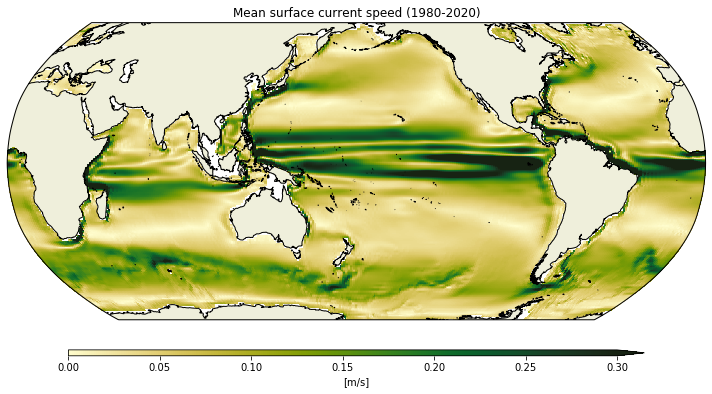

In [3]:
fignum = '04_02'
U = xr.open_mfdataset(datadir+'GODAS/ucur*', combine='by_coords')
V = xr.open_mfdataset(datadir+'GODAS/vcur*', combine='by_coords')
spd = np.hypot(U.ucur.isel(level=0).mean('time'), V.vcur.isel(level=0).mean('time'))

projection = cartopy.crs.Robinson(central_longitude=180)
fig = plt.figure(figsize=(10, 5.5), constrained_layout=True)
gs = gridspec.GridSpec(2, 1, height_ratios=[6, 1])
ax = fig.add_subplot(gs[0], projection=projection)

ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.LAND)

a = spd.plot(cmap=cmo.speed, vmin=0, vmax=0.3, add_colorbar=False,
             transform=cartopy.crs.PlateCarree(), rasterized=True)
plt.title('Mean surface current speed (1980-2020)')

cbaxes = fig.add_axes([0.1, 0.09, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='max', label='[m/s]', use_gridspec=True)

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

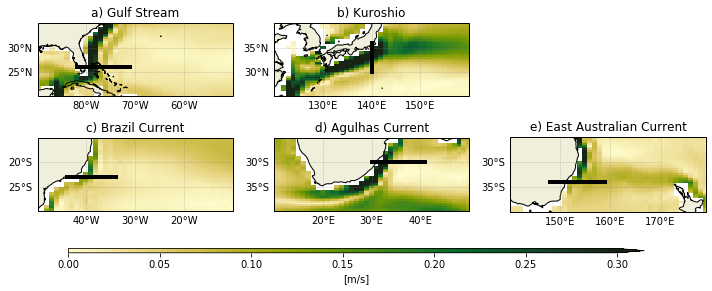

In [4]:
fignum = '04_03'
U = xr.open_mfdataset(datadir+'GODAS/ucur*', combine='by_coords')
V = xr.open_mfdataset(datadir+'GODAS/vcur*', combine='by_coords')
spd = np.hypot(U.ucur.isel(level=0).mean('time'), V.vcur.isel(level=0).mean('time'))

projection = cartopy.crs.PlateCarree()
fig = plt.figure(figsize=(10, 4), constrained_layout=True)
gs = gridspec.GridSpec(3, 3, height_ratios=[3, 3, 1])

lons = [slice(270, 310), slice(120, 160), slice(310, 350), slice(10, 50), slice(140,179)]
lats = [slice(20, 35), slice(25, 40), slice(-30, -15), slice(-40, -25), slice(-40, -25)]
section_lons = [slice(278, 289), 140, slice(316, 326), slice(30, 41), slice(148, 159)]
section_lats = [26, slice(30, 36), -23, -30, -34]
subplots= [[0, 0], [0, 1], [1, 0], [1, 1], [1, 2]]
titles = ['a) Gulf Stream', 'b) Kuroshio', 'c) Brazil Current', 'd) Agulhas Current', 'e) East Australian Current']
for i in range(len(lons)):
    ai = fig.add_subplot(gs[subplots[i][0], subplots[i][1]], projection=projection)

    ai.coastlines(resolution='50m')
    ai.add_feature(cartopy.feature.LAND)
    a = spd.sel(lon=lons[i], lat=lats[i]).plot(cmap=cmo.speed, vmin=0, vmax=0.3, transform=cartopy.crs.PlateCarree(), 
                                           ax=ai, add_colorbar=False, rasterized=True)
    ai.set_title(titles[i])
    if isinstance(section_lons[i], slice):
        linelons, linelats = (section_lons[i].start, section_lons[i].stop), (section_lats[i], section_lats[i])
    else:
        linelons, linelats = (section_lons[i], section_lons[i]), (section_lats[i].start, section_lats[i].stop)
    ai.plot(linelons, linelats, 'k', linewidth=4, transform=cartopy.crs.PlateCarree())
    ai.set_extent([lons[i].start, lons[i].stop, lats[i].start, lats[i].stop], crs=cartopy.crs.PlateCarree())

    gl = ai.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=False, linewidth=0.5,
                      color='gray', alpha=0.5, linestyle='--')
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 10))
    gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 5))
    gl.xlabels_bottom = True
    gl.xformatter = LONGITUDE_FORMATTER
    gl.ylabels_left = True
    gl.yformatter = LATITUDE_FORMATTER

cbaxes = fig.add_axes([0.1, 0.11, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='max', label='[m/s]')
fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

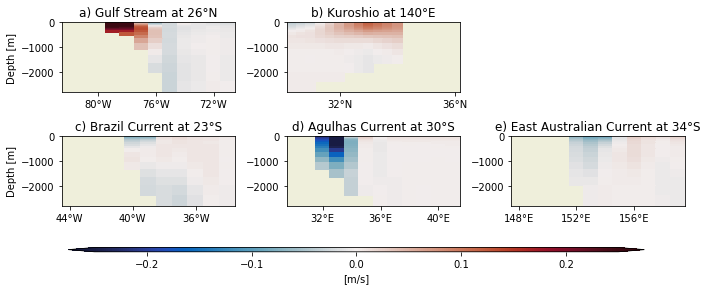

In [5]:
fignum = '04_04'
U = xr.open_mfdataset(datadir+'GODAS/ucur*', combine='by_coords')
V = xr.open_mfdataset(datadir+'GODAS/vcur*', combine='by_coords')

fig = plt.figure(figsize=(10, 4), constrained_layout=True)
gs = gridspec.GridSpec(3, 3, height_ratios=[3, 3, 1])

lons = [slice(278, 289), 140, slice(316, 326), slice(30, 41), slice(148, 159)]
lats = [26, slice(30, 36), -23, -30, -34]
subplots= [[0, 0], [0, 1], [1, 0], [1, 1], [1, 2]]
titles = ['a) Gulf Stream at 26%sN' % degsym, 'b) Kuroshio at 140%sE' % degsym, 'c) Brazil Current at 23%sS' %degsym, 'd) Agulhas Current at 30%sS' %degsym, 'e) East Australian Current at 34%sS' %degsym]
for i in range(len(lons)):
    ai = fig.add_subplot(gs[subplots[i][0], subplots[i][1]])    
    if isinstance(lons[i], slice):
        vel = V.vcur.sel(lat=lats[i], method='nearest').sel(lon=lons[i], level=slice(0, 3000)).mean('time')
        vel = vel.assign_coords(level = (-vel.level))
        if vel.lon[0] > 180:
            vel = vel.assign_coords(lon = vel.lon-360)
        formatter = LONGITUDE_FORMATTER
    else:
        vel = V.vcur.sel(lon=lons[i], method='nearest').sel(lat=lats[i], level=slice(0, 3000)).mean('time')
        vel = vel.assign_coords(level = (-vel.level))
        formatter = LATITUDE_FORMATTER
    a = vel.plot(cmap=cmo.balance, ax=ai, add_colorbar=False, vmin=-0.25, vmax=0.25, rasterized=True)
    ai.set_title(titles[i])
    if i ==0 or i == 2:
        ai.set_ylabel('Depth [m]')
    else:
        ai.set_ylabel('')
    ai.xaxis.set_major_formatter(formatter)
    ai.xaxis.set_major_locator(mticker.MultipleLocator(4))
    ai.set_xlabel('')
    ai.set_facecolor([0.9375 , 0.9375 , 0.859375])

cbaxes = fig.add_axes([0.1, 0.11, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='both', label='[m/s]')
fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

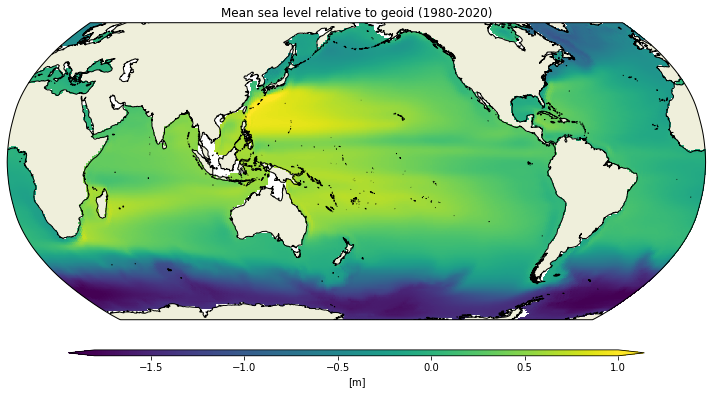

In [6]:
fignum = '04_05'
SSH = xr.open_mfdataset(datadir+'GODAS/ssh*', combine='by_coords')

projection = cartopy.crs.Robinson(central_longitude=180)
fig = plt.figure(figsize=(10, 5.5), constrained_layout=True)
gs = gridspec.GridSpec(2, 1, height_ratios=[6, 1])
ax = fig.add_subplot(gs[0], projection=projection)
ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.LAND)

a = SSH.sshg.mean('time').plot(cmap=cm.viridis, vmin=-1.8, vmax=1, add_colorbar=False, 
                               transform=cartopy.crs.PlateCarree(), rasterized=True)
plt.title('Mean sea level relative to geoid (1980-2020)')

cbaxes = fig.add_axes([0.1, 0.09, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='both', label='[m]', use_gridspec=True)

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

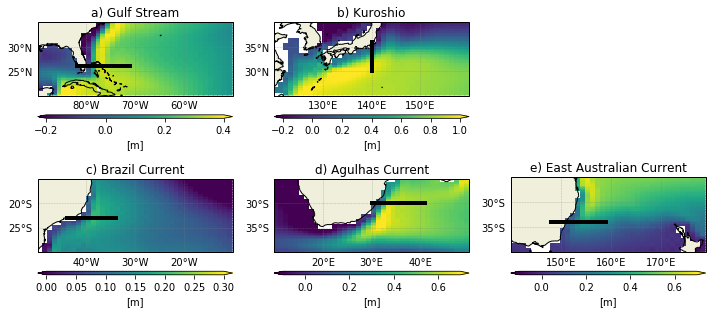

In [7]:
fignum = '04_06'
SSH = xr.open_mfdataset(datadir+'GODAS/ssh*', combine='by_coords')

projection = cartopy.crs.PlateCarree()
fig, ax = plt.subplots(2, 3, subplot_kw={'projection': projection}, figsize=(10, 4.5))
ax[0, 2].remove()
ax = np.delete(ax, 2)

lons = [slice(270, 310), slice(120, 160), slice(310, 350), slice(10, 50), slice(140,179)]
lats = [slice(20, 35), slice(25, 40), slice(-30, -15), slice(-40, -25), slice(-40, -25)]
section_lons = [slice(278, 289), 140, slice(316, 326), slice(30, 41), slice(148, 159)]
section_lats = [26, slice(30, 36), -23, -30, -34]
vlims = [[-0.2, 0.4], [-0.2, 1], [0, 0.3], [-0.1, 0.7], [-0.1, 0.7]]
titles = ['a) Gulf Stream', 'b) Kuroshio', 'c) Brazil Current', 'd) Agulhas Current', 'e) East Australian Current']
for i, ai in enumerate(ax.ravel()):
    ai.coastlines(resolution='50m')
    ai.add_feature(cartopy.feature.LAND)
    a = SSH.sshg.mean('time').sel(lon=lons[i], lat=lats[i]).plot(cmap=cm.viridis, vmin=vlims[i][0], vmax=vlims[i][1], 
                                                                 transform=cartopy.crs.PlateCarree(), 
                                                                 ax=ai, add_colorbar=False)
    ai.set_title(titles[i])
    if isinstance(section_lons[i], slice):
        linelons, linelats = (section_lons[i].start, section_lons[i].stop), (section_lats[i], section_lats[i])
    else:
        linelons, linelats = (section_lons[i], section_lons[i]), (section_lats[i].start, section_lats[i].stop)
    ai.plot(linelons, linelats, 'k', linewidth=4, transform=cartopy.crs.PlateCarree(), rasterized=True)
    ai.set_extent([lons[i].start, lons[i].stop, lats[i].start, lats[i].stop], crs=cartopy.crs.PlateCarree())

    gl = ai.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=False, linewidth=0.5,
                      color='gray', alpha=0.5, linestyle='--')
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 10))
    gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 5))
    gl.xlabels_bottom = True
    gl.xformatter = LONGITUDE_FORMATTER
    gl.ylabels_left = True
    gl.yformatter = LATITUDE_FORMATTER

    plt.colorbar(a, ax=ai, orientation="horizontal", aspect=50, extend='both', label='[m]')
fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

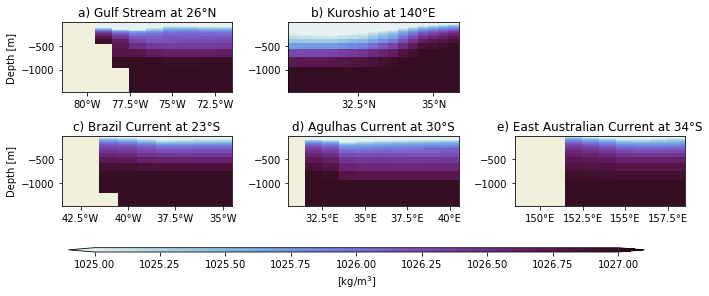

In [8]:
fignum = '04_07'
T = xr.open_mfdataset(datadir+'GODAS/pottmp*', combine='by_coords')
S = xr.open_mfdataset(datadir+'GODAS/salt*', combine='by_coords')
fig = plt.figure(figsize=(10, 4), constrained_layout=True)
gs = gridspec.GridSpec(3, 3, height_ratios=[3, 3, 1])

lons = [slice(278, 289), 140, slice(316, 326), slice(30, 41), slice(148, 159)]
lats = [26, slice(30, 36), -23, -30, -34]
titles = ['a) Gulf Stream at 26N', 'b) Kuroshio at 140E', 'c) Brazil Current at 23S', 'd) Agulhas Current at 30S', 'e) East Australian Current at 34S']
subplots= [[0, 0], [0, 1], [1, 0], [1, 1], [1, 2]]
titles = ['a) Gulf Stream at 26%sN' % degsym, 'b) Kuroshio at 140%sE' % degsym, 'c) Brazil Current at 23%sS' %degsym, 'd) Agulhas Current at 30%sS' %degsym, 'e) East Australian Current at 34%sS' %degsym]
for i in range(len(lons)):
    ai = fig.add_subplot(gs[subplots[i][0], subplots[i][1]])    
    if isinstance(lons[i], slice):
        salt = S.salt.sel(lat=lats[i], method='nearest').sel(lon=lons[i], level=slice(0, 1800)).mean('time')
        temp = T.pottmp.sel(lat=lats[i], method='nearest').sel(lon=lons[i], level=slice(0, 1800)).mean('time')
        if salt.lon[0] > 180:
            salt = salt.assign_coords(lon = salt.lon-360)
        x, formatter = salt.lon, LONGITUDE_FORMATTER
    else:
        salt = S.salt.sel(lon=lons[i], method='nearest').sel(lat=lats[i], level=slice(0, 1800)).mean('time')
        temp = T.pottmp.sel(lon=lons[i], method='nearest').sel(lat=lats[i], level=slice(0, 1800)).mean('time')
        x, formatter = salt.lat, LATITUDE_FORMATTER
    dens = gsw.density.sigma0(salt*1000, temp-273.15)+1000
    a = ai.pcolormesh(x, -salt.level, dens, cmap=cmo.dense, vmin=1025, vmax=1027, rasterized=True)
    ai.set_title(titles[i])
    if i ==0 or i == 2:
        ai.set_ylabel('Depth [m]')
    else:
        ai.set_ylabel('')
    ai.xaxis.set_major_formatter(formatter)
    ai.xaxis.set_major_locator(mticker.MultipleLocator(2.5))
    ai.set_xlabel('')
    ai.set_facecolor([0.9375 , 0.9375 , 0.859375])

cbaxes = fig.add_axes([0.1, 0.11, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='both', label='[kg/m$^3$]')
fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

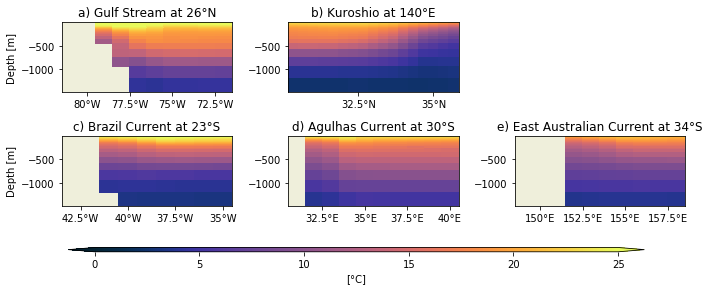

In [9]:
fignum = '04_08'
T = xr.open_mfdataset(datadir+'GODAS/pottmp*', combine='by_coords')
fig = plt.figure(figsize=(10, 4), constrained_layout=True)
gs = gridspec.GridSpec(3, 3, height_ratios=[3, 3, 1])

lons = [slice(278, 289), 140, slice(316, 326), slice(30, 41), slice(148, 159)]
lats = [26, slice(30, 36), -23, -30, -34]
subplots= [[0, 0], [0, 1], [1, 0], [1, 1], [1, 2]]
titles = ['a) Gulf Stream at 26%sN' % degsym, 'b) Kuroshio at 140%sE' % degsym, 'c) Brazil Current at 23%sS' %degsym, 'd) Agulhas Current at 30%sS' %degsym, 'e) East Australian Current at 34%sS' %degsym]
for i in range(len(lons)):
    ai = fig.add_subplot(gs[subplots[i][0], subplots[i][1]])    
    if isinstance(lons[i], slice):
        temp = T.pottmp.sel(lat=lats[i], method='nearest').sel(lon=lons[i], level=slice(0, 1800)).mean('time')
        if temp.lon[0] > 180:
            temp = temp.assign_coords(lon = temp.lon-360)
        x, formatter = temp.lon, LONGITUDE_FORMATTER
    else:
        temp = T.pottmp.sel(lon=lons[i], method='nearest').sel(lat=lats[i], level=slice(0, 1800)).mean('time')
        x, formatter = temp.lat, LATITUDE_FORMATTER
    a = ai.pcolormesh(x, -temp.level, temp-273.15, cmap=cmo.thermal, vmin=0, vmax=25, rasterized=True)
    ai.set_title(titles[i])
    if i ==0 or i == 2:
        ai.set_ylabel('Depth [m]')
    else:
        ai.set_ylabel('')
    ai.xaxis.set_major_formatter(formatter)
    ai.xaxis.set_major_locator(mticker.MultipleLocator(2.5))
    ai.set_xlabel('')
    ai.set_facecolor([0.9375 , 0.9375 , 0.859375])

cbaxes = fig.add_axes([0.1, 0.11, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='both', label='[%sC]' %degsym)
fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

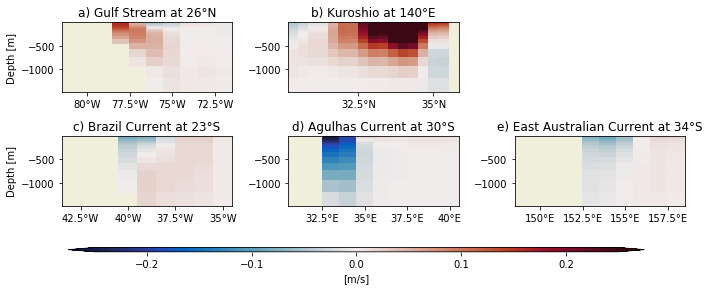

In [10]:
fignum = '04_10'

T = xr.open_mfdataset(datadir+'GODAS/pottmp*', combine='by_coords')
S = xr.open_mfdataset(datadir+'GODAS/salt*', combine='by_coords')
fig = plt.figure(figsize=(10, 4), constrained_layout=True)
gs = gridspec.GridSpec(3, 3, height_ratios=[3, 3, 1])

lons = [slice(278, 289), 140, slice(316, 326), slice(30, 41), slice(148, 159)]
lats = [26, slice(30, 36), -23, -30, -34]
subplots= [[0, 0], [0, 1], [1, 0], [1, 1], [1, 2]]
titles = ['a) Gulf Stream at 26%sN' % degsym, 'b) Kuroshio at 140%sE' % degsym, 'c) Brazil Current at 23%sS' %degsym, 'd) Agulhas Current at 30%sS' %degsym, 'e) East Australian Current at 34%sS' %degsym]
for i in range(len(lons)):
    ai = fig.add_subplot(gs[subplots[i][0], subplots[i][1]])    
    if isinstance(lons[i], slice):
        salt = S.salt.sel(lat=lats[i], method='nearest').sel(lon=lons[i], level=slice(0, 1800)).mean('time')
        temp = T.pottmp.sel(lat=lats[i], method='nearest').sel(lon=lons[i], level=slice(0, 1800)).mean('time')
        if temp.lon[0] > 180:
            temp = temp.assign_coords(lon = temp.lon-360)
        x, formatter = temp.lon, LONGITUDE_FORMATTER
        dx, corio, dirsign = np.gradient(x*60*1852*np.cos(lats[i]/180*np.pi)), gsw.f(lats[i]), 1
    else:
        salt = S.salt.sel(lon=lons[i], method='nearest').sel(lat=lats[i], level=slice(0, 1800)).mean('time')
        temp = T.pottmp.sel(lon=lons[i], method='nearest').sel(lat=lats[i], level=slice(0, 1800)).mean('time')
        x, formatter = temp.lat, LATITUDE_FORMATTER
        dx, corio, dirsign = np.gradient(x*60*1852*np.cos(np.mean(x)/180*np.pi)), gsw.f(np.mean(x)), -1

    dens = gsw.density.sigma0(salt*1000, temp-273.15)+1000
    dens_dx = np.gradient(dens, np.mean(dx), axis=1)

    dZ = np.tile(np.gradient(salt.level), (x.size, 1)).T
    densZ = dens_dx * dZ
    densZ[np.isnan(densZ)] = 0.
    dens_int = -np.cumsum(densZ[::-1], axis=0)[::-1]  # minus sign because of inverse summing
    vel = dirsign * 9.81 / (1025 * corio) * dens_int
    vel[vel==0] = np.nan

    a = ai.pcolormesh(x, -salt.level, vel, cmap=cmo.balance, vmin=-0.25, vmax=0.25, rasterized=True)

    ai.set_title(titles[i])
    if i ==0 or i == 2:
        ai.set_ylabel('Depth [m]')
    else:
        ai.set_ylabel('')
    ai.xaxis.set_major_formatter(formatter)
    ai.xaxis.set_major_locator(mticker.MultipleLocator(2.5))
    ai.set_xlabel('')
    ai.set_facecolor([0.9375 , 0.9375 , 0.859375])

cbaxes = fig.add_axes([0.1, 0.11, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='both', label='[m/s]')
fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

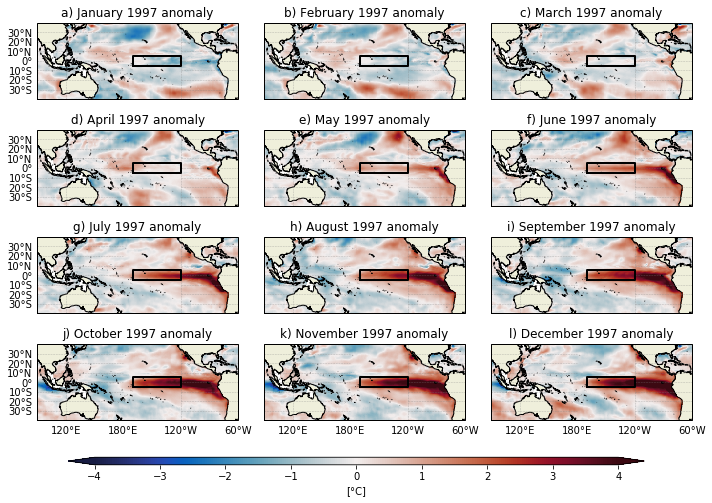

In [11]:
fignum = '06_22'

T = xr.open_mfdataset(datadir+'GODAS/pottmp*', combine='by_coords').pottmp.isel(level=0).sel(lon=slice(90, 300), lat=slice(-40, 40))
climatology = T.groupby("time.month").mean("time")
anomalies = T.groupby("time.month") - climatology

projection = cartopy.crs.PlateCarree(central_longitude=180)
fig = plt.figure(figsize=(10, 7), constrained_layout=True)
hr = 2
gs = gridspec.GridSpec(5, 3, height_ratios=[hr, hr, hr, hr, 1]) 

for col in range(3):
    for row in range(4):
        ai = fig.add_subplot(gs[row, col], projection=projection)
        ai.coastlines(resolution='50m')
        ai.add_feature(cartopy.feature.LAND)
        i = row*3 + col
        temp = anomalies.sel(time='1997-%.2d-01' % (i+1))
        a = temp.plot(cmap=cmo.balance, vmin=-4, vmax=4,
                      transform=cartopy.crs.PlateCarree(), 
                      ax=ai, add_colorbar=False, rasterized=True)
        ai.plot([-170, -120, -120, -170, -170], [-5, -5, 5, 5, -5], 'k', linewidth=2, 
                transform=cartopy.crs.PlateCarree())
        ai.set_title('%s) %s anomaly' % (chr(ord('a') + i), temp.time.dt.strftime('%B %Y').values))
        ai.set_extent([90, 300, -40, 40], crs=cartopy.crs.PlateCarree())

        gl = ai.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=False, linewidth=0.5,
                          color='gray', alpha=0.5, linestyle='--')
        gl.xlocator = mticker.FixedLocator([-120, -60, 120, 180])
        if row == 3:
            gl.xlabels_bottom = True
            gl.xformatter = LONGITUDE_FORMATTER
        if col == 0:
            gl.ylabels_left = True
            gl.yformatter = LATITUDE_FORMATTER

cbaxes = fig.add_axes([0.1, 0.07, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='both', label='[%sC]' %degsym, use_gridspec=True)
fig.canvas.draw()
plt.tight_layout()

savefig(fignum)

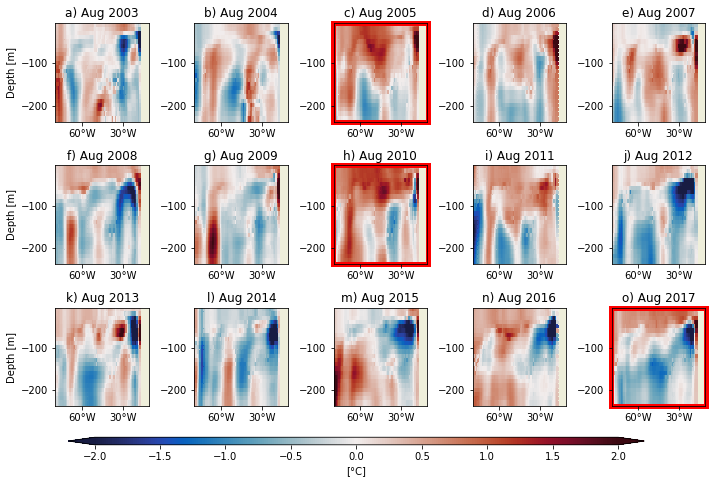

In [12]:
fignum = '06_27'

T = xr.open_mfdataset(datadir+'GODAS/pottmp*', combine='by_coords').pottmp.sel(lat=15, method='nearest').sel(lon=slice(280, 350), level=slice(0, 250))
climatology = T.groupby("time.month").mean("time")
anomalies = T.groupby("time.month") - climatology

fig = plt.figure(figsize=(10, 7), constrained_layout=True)
hr = 2.5
gs = gridspec.GridSpec(4, 5, height_ratios=[hr, hr, hr, 1]) 

for col in range(5):
    for row in range(3):
        ai = fig.add_subplot(gs[row, col])
        i = row*5 + col
        temp = anomalies.sel(time='%d-08-01' % (i+2003))
        temp = temp.assign_coords(lon = temp.lon-360)
        a = ai.pcolormesh(temp.lon, -temp.level, temp, cmap=cmo.balance, vmin=-2, vmax=2, rasterized=True)
        ai.set_title('%s) %s' % (chr(ord('a') + i), temp.time.dt.strftime('%b %Y').values))
        ai.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
        ai.xaxis.set_major_locator(mticker.MultipleLocator(30))
        ai.set_xlabel('')
        if col == 0:
            ai.set_ylabel('Depth [m]')
        ai.set_facecolor([0.9375 , 0.9375 , 0.859375])
        if i in [2, 7, 14]:
            rec = Rectangle((ai.axis()[0]-0.7, ai.axis()[2]-0.2), 
                            (ai.axis()[1]- ai.axis()[0])+1, (ai.axis()[3]-ai.axis()[2])+0.4,
                            fill=False, lw=5, color='r')
            rec = ai.add_patch(rec)
            rec.set_clip_on(False)

cbaxes = fig.add_axes([0.1, 0.11, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='both', label='[%sC]' %degsym)
fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

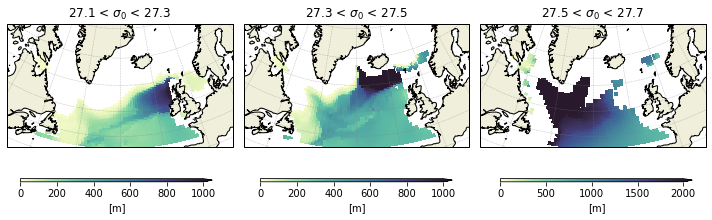

In [13]:
fignum = '07_20'

T = xr.open_mfdataset(datadir+'GODAS/pottmp*', combine='by_coords').pottmp.sel(lat=slice(45, 70)).groupby('time.month').mean("time")
S = xr.open_mfdataset(datadir+'GODAS/salt*', combine='by_coords').salt.sel(lat=slice(45, 70)).groupby('time.month').mean("time")
dens = gsw.density.sigma0(S*1000, T-273.15)

sig0 = [27.1, 27.3, 27.5, 27.7]
vmax = [1000, 1000, 2000]
mon = 3

projection = cartopy.crs.LambertConformal(central_longitude=-30)
# fig, ax = plt.subplots(1, 3, subplot_kw={'projection': projection}, figsize=(15, 5))
fig = plt.figure(figsize=(10, 3), constrained_layout=True)

gs = gridspec.GridSpec(2, 3, height_ratios=[3, 1]) 

for i in range(len(sig0)-1):
    ai = fig.add_subplot(gs[0, i], projection=projection)

    pd0, pd1 = sig0[i], sig0[i+1]
    thickness = np.nan * np.ones((dens.shape[2], dens.shape[3]))
    for x in range(thickness.shape[1]):
        for y in range(thickness.shape[0]):
            if dens[mon, 0, y, x] < pd1:
                thickness[y, x] = np.interp(pd1, dens[mon, :, y, x], S.level) - np.interp(pd0, dens[mon, :, y, x], S.level)

    ai.coastlines(resolution='50m')
    ai.add_feature(cartopy.feature.LAND)
    a = ai.pcolormesh(T.lon, T.lat, thickness, cmap=cmo.deep, transform=cartopy.crs.PlateCarree(), 
                      vmin=0, vmax=vmax[i], rasterized=True)
    ai.set_title('%.1f < $\sigma_0$ < %.1f' % (pd0, pd1))
    ai.set_extent([-70, 10, 45, 70], crs=cartopy.crs.PlateCarree())
    
    gl = ai.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=False, linewidth=0.5,
                      color='gray', alpha=0.5, linestyle='--')

    cbaxes = fig.add_axes([(0.1+i)/3, 0.15, 0.8/3, 0.015])
    plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=50, extend='max', label='[m]')
fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

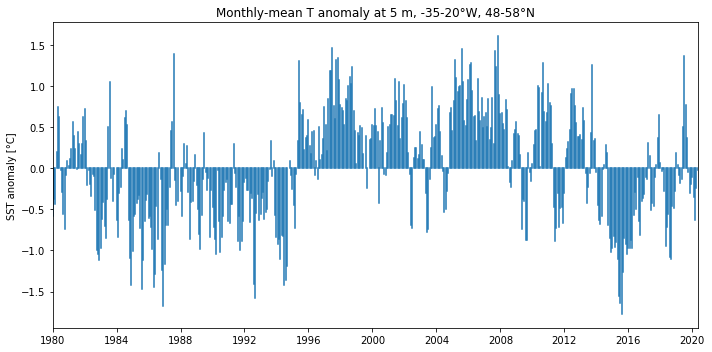

In [14]:
fignum = '07_34'

T = xr.open_mfdataset(datadir+'GODAS/pottmp*', combine='by_coords')
temp = T.pottmp.isel(level=0).sel(lat=slice(48, 58), lon=slice(360-35, 360-20)).mean('lon').mean('lat')

climatology = temp.groupby("time.month").mean("time")
anomalies = temp.groupby("time.month") - climatology

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.stem(temp.time, anomalies, markerfmt=" ", basefmt=" ")
plt.ylabel('SST anomaly [%sC]' %degsym)
plt.xlim([temp.time[0].values, temp.time[-1].values])
plt.title('Monthly-mean T anomaly at %d m, -35-20%sW, 48-58%sN' % (temp.level.values, degsym, degsym))

plt.tight_layout()
savefig(fignum)

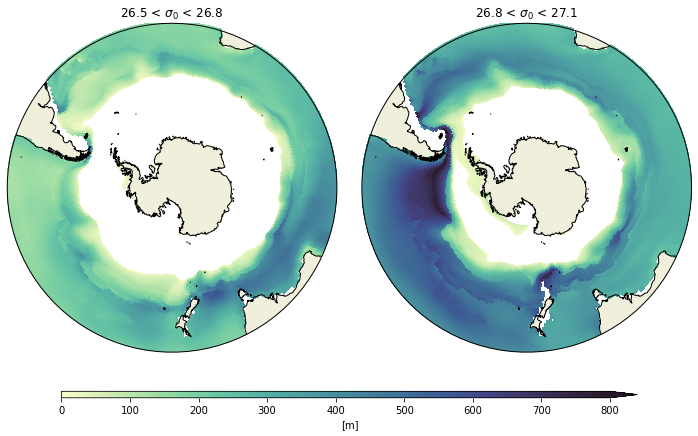

In [15]:
fignum = '08_21'

T = xr.open_mfdataset(datadir+'GODAS/pottmp*', combine='by_coords').pottmp.sel(lat=slice(-90, -30)).groupby('time.month').mean("time")
S = xr.open_mfdataset(datadir+'GODAS/salt*', combine='by_coords').salt.sel(lat=slice(-90, -30)).groupby('time.month').mean("time")
dens = gsw.density.sigma0(S*1000, T-273.15)

sig0 = [26.5, 26.8, 27.1]
mon = 9

projection = cartopy.crs.SouthPolarStereo()
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = gridspec.GridSpec(2, 2, height_ratios=[6, 1]) 

for i in range(len(sig0)-1):
    ai = fig.add_subplot(gs[0, i], projection=projection)
    pd0, pd1 = sig0[i], sig0[i+1]
    thickness = np.nan * np.ones((dens.shape[2], dens.shape[3]))
    for x in range(thickness.shape[1]):
        for y in range(thickness.shape[0]):
            if dens[mon, 0, y, x] < pd1:
                thickness[y, x] = np.interp(pd1, dens[mon, :, y, x], S.level) - np.interp(pd0, dens[mon, :, y, x], S.level)

    ai.coastlines(resolution='50m')
    ai.add_feature(cartopy.feature.LAND)
    a = ai.pcolormesh(cartopy.util.add_cyclic_point(T.lon), T.lat, cartopy.util.add_cyclic_point(thickness), 
                      cmap=cmo.deep, transform=cartopy.crs.PlateCarree(), vmin=0, vmax=800, rasterized=True)
    ai.set_title('%.1f < $\sigma_0$ < %.1f' % (pd0, pd1))
    
    ai.set_extent([-180, 180, -90, -30], cartopy.crs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ai.set_boundary(circle, transform=ai.transAxes)

cbaxes = fig.add_axes([0.1, 0.07, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='max', label='[m]', use_gridspec=True)
fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

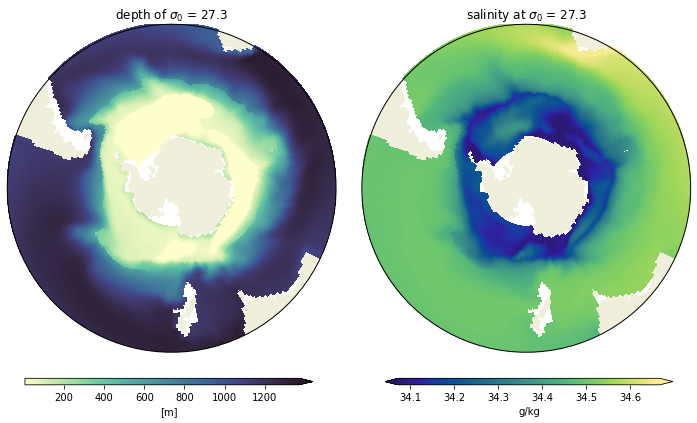

In [16]:
fignum = '08_24'

T = xr.open_mfdataset(datadir+'GODAS/pottmp*', combine='by_coords').pottmp.sel(lat=slice(-90, -30)).groupby('time.month').mean("time")
S = xr.open_mfdataset(datadir+'GODAS/salt*', combine='by_coords').salt.sel(lat=slice(-90, -30)).groupby('time.month').mean("time")
S = S.compute()
dens = gsw.density.sigma0(S*1000, T-273.15)
sig0 = 27.3
mon = 9

depth = np.nan * np.ones((dens.shape[2], dens.shape[3]))
salt = np.nan * np.ones((dens.shape[2], dens.shape[3]))
for x in range(depth.shape[1]):
    for y in range(depth.shape[0]):
        d = np.interp(sig0, dens[mon, :, y, x], T.level)
        depth[y, x] = d
        salt[y, x] = np.interp(d, T.level, S[mon, :, y, x])*1000

projection = cartopy.crs.SouthPolarStereo()
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = gridspec.GridSpec(2, 2, height_ratios=[6, 1]) 

for i in range(2):
    ai = fig.add_subplot(gs[0, i], projection=projection)
    ai.add_feature(cartopy.feature.LAND)
    
    if i == 0:
        var = depth
        ai.set_title('depth of $\sigma_0$ = %.1f' % sig0)
        unit, cmap, extend  = '[m]', cmo.deep, 'max'
    else:
        var = salt
        ai.set_title('salinity at $\sigma_0$ = %.1f' % sig0)
        unit, cmap, extend = 'g/kg', cmo.haline, 'both'
    a = ai.pcolormesh(cartopy.util.add_cyclic_point(T.lon), T.lat, cartopy.util.add_cyclic_point(var), 
                      cmap=cmap, transform=cartopy.crs.PlateCarree(), rasterized=True)
    
    ai.set_extent([-180, 180, -90, -30], cartopy.crs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ai.set_boundary(circle, transform=ai.transAxes)

    cbaxes = fig.add_axes([(0.1+i)/2, 0.1, 0.8/2, 0.015])
    plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=50, extend=extend, label=unit)

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

In [17]:
fignum = '08_25'

#TODO: need to find propper neutral density implementation in Python!

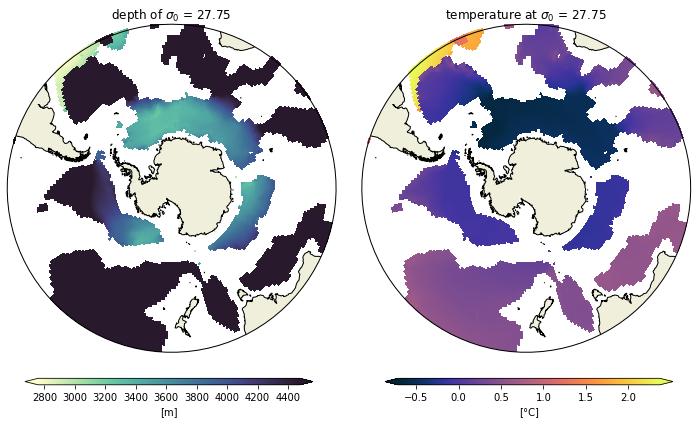

In [18]:
fignum = '08_26'

T = xr.open_mfdataset(datadir+'GODAS/pottmp*', combine='by_coords').pottmp.sel(lat=slice(-90, -30)).groupby('time.month').mean("time")
S = xr.open_mfdataset(datadir+'GODAS/salt*', combine='by_coords').salt.sel(lat=slice(-90, -30)).groupby('time.month').mean("time")
T = T.compute()
dens = gsw.density.sigma0(S*1000, T-273.15)
sig0 = 27.75
mon = 9

depth = np.nan * np.ones((dens.shape[2], dens.shape[3]))
temp = np.nan * np.ones((dens.shape[2], dens.shape[3]))
for x in range(depth.shape[1]):
    for y in range(depth.shape[0]):
        d = np.interp(sig0, dens[mon, :, y, x], S.level)
        depth[y, x] = d
        temp[y, x] = np.interp(d, S.level, T[mon, :, y, x])-273.15

projection = cartopy.crs.SouthPolarStereo()
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = gridspec.GridSpec(2, 2, height_ratios=[6, 1]) 

for i in range(2):
    ai = fig.add_subplot(gs[0, i], projection=projection)
    ai.coastlines(resolution='50m')
    ai.add_feature(cartopy.feature.LAND)
    
    if i == 0:
        var = depth
        ai.set_title('depth of $\sigma_0$ = %.2f' % sig0)
        unit, cmap  = '[m]', cmo.deep
    else:
        var = temp
        ai.set_title('temperature at $\sigma_0$ = %.2f' % sig0)
        unit, cmap = '[%sC]' %degsym, cmo.thermal
    a = ai.pcolormesh(cartopy.util.add_cyclic_point(T.lon), T.lat, cartopy.util.add_cyclic_point(var), 
                      cmap=cmap, transform=cartopy.crs.PlateCarree(), rasterized=True)
    
    ai.set_extent([-180, 180, -90, -30], cartopy.crs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ai.set_boundary(circle, transform=ai.transAxes)

    cbaxes = fig.add_axes([(0.1+i)/2, 0.1, 0.8/2, 0.015])
    plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=50, extend='both', label=unit)

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

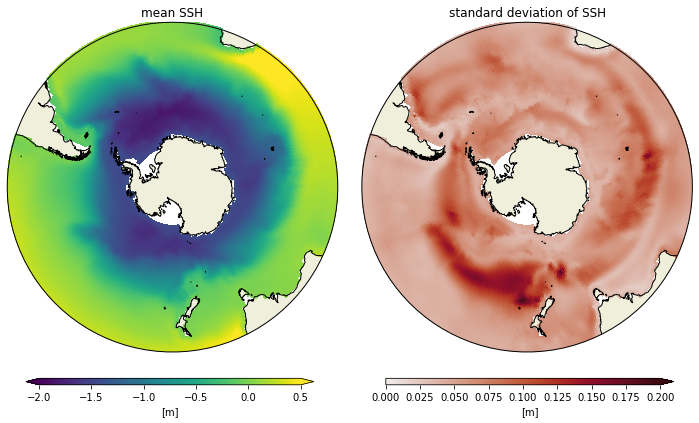

In [19]:
fignum = '08_30'

SSH = xr.open_mfdataset(datadir+'GODAS/ssh*', combine='by_coords').sshg.sel(lat=slice(-90, -30))

projection = cartopy.crs.SouthPolarStereo()
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = gridspec.GridSpec(2, 2, height_ratios=[6, 1]) 

for i in range(2):
    ai = fig.add_subplot(gs[0, i], projection=projection)
    ai.coastlines(resolution='50m')
    ai.add_feature(cartopy.feature.LAND)
    
    if i == 0:
        var, cmap, vrange, extend = SSH.mean('time'), cm.viridis, [-2, 0.5], 'both'
        ai.set_title('mean SSH')
    else:
        var, cmap, vrange, extend = SSH.std('time'), cmo.amp, [0, 0.2], 'max'
        ai.set_title('standard deviation of SSH')
    a = ai.pcolormesh(cartopy.util.add_cyclic_point(T.lon), T.lat, cartopy.util.add_cyclic_point(var), 
                      cmap=cmap, vmin=vrange[0], vmax=vrange[1], transform=cartopy.crs.PlateCarree(), rasterized=True)
    
    ai.set_extent([-180, 180, -90, -30], cartopy.crs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ai.set_boundary(circle, transform=ai.transAxes)

    cbaxes = fig.add_axes([(0.1+i)/2, 0.1, 0.8/2, 0.015])
    plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=50, extend=extend, label='[m]')

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

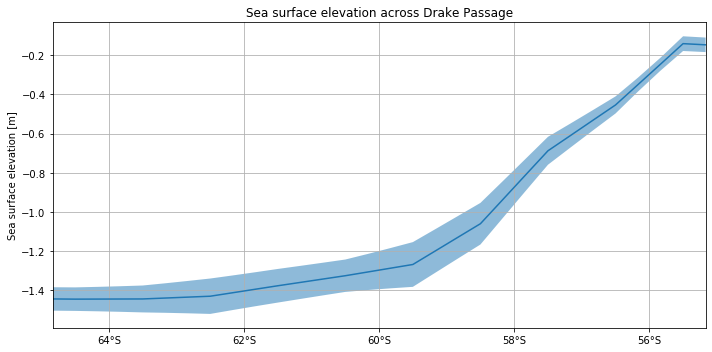

In [20]:
fignum = '08_31'

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

SSH = xr.open_mfdataset(datadir+'GODAS/ssh*', combine='by_coords').sshg.sel(lat=slice(-65, -55)).sel(lon=360-65, method='nearest')

ax.plot(SSH.lat, SSH.mean('time'))
ax.fill_between(SSH.lat, SSH.mean('time')-SSH.std('time'), SSH.mean('time')+SSH.std('time'), alpha=0.5)
ax.set_ylabel('')
ax.xaxis.set_major_formatter(LATITUDE_FORMATTER)
ax.xaxis.set_major_locator(mticker.MultipleLocator(2))
ax.set_xlim([SSH.lat[0], SSH.lat[-1]])
plt.ylabel('Sea surface elevation [m]')
plt.title('Sea surface elevation across Drake Passage')
ax.grid()
plt.tight_layout()
savefig(fignum)

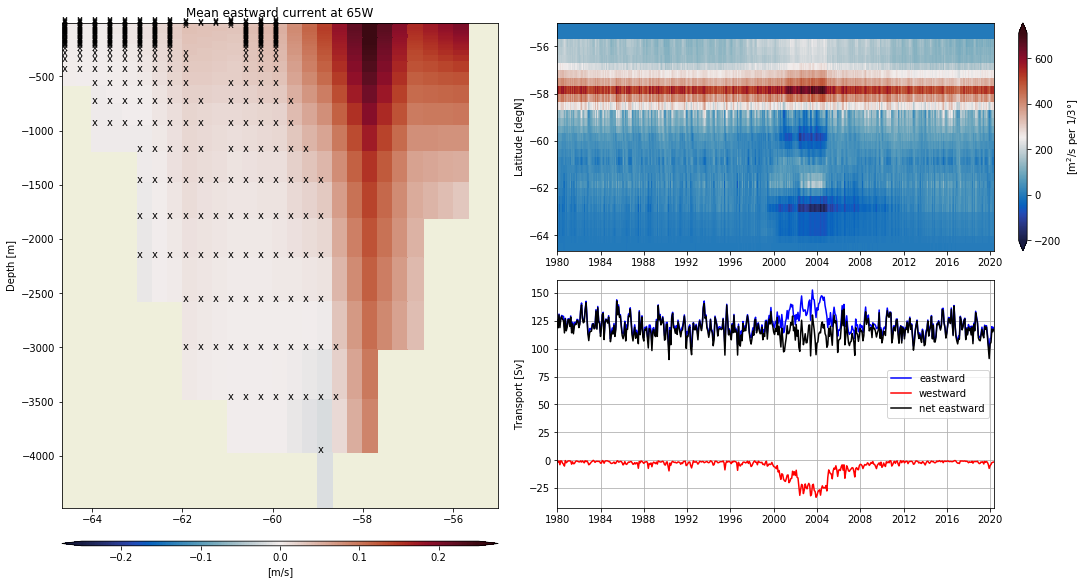

In [21]:
fignum = '08_32'

U = xr.open_mfdataset(datadir+'GODAS/ucur*', combine='by_coords').ucur.sel(lat=slice(-65, -55)).sel(lon=360-65, method='nearest')

fig = plt.figure(constrained_layout=True, figsize=(15, 8))
gs = fig.add_gridspec(2, 2)

ax0 = fig.add_subplot(gs[:, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 1])

a = ax0.pcolormesh(U.lat, -U.level, U.mean('time'), cmap=cmo.balance, vmin=-0.25, vmax=0.25, rasterized=True)
ax0.set_title('Mean eastward current at 65W')
ax0.set_ylabel('Depth [m]')
ax0.set_facecolor([0.9375 , 0.9375 , 0.859375])
plt.colorbar(a, ax=ax0, orientation="horizontal", aspect=50, extend='both', label='[m/s]')
wward = U.where(U<0).mean('time').values
for z in range(wward.shape[0]):
    for y in range(wward.shape[1]):
        if np.isfinite(wward[z, y]):
            ax0.text(U.lat.values[y], -U.level.values[z],'x', color='k')

a = ax1.pcolormesh(U.time, U.lat, U.fillna(0).integrate('level').T, cmap=cmo.balance, rasterized=True)
ax1.set_ylabel('Latitude [degN]')
plt.colorbar(a, ax=ax1, aspect=50, extend='both', label='[m$^2$/s per 1/3%s]' %degsym)

ax2.plot(U.time, U.where(U>0).fillna(0).integrate('level').integrate('lat')*1852*60/1e6, 'b', label='eastward')
ax2.plot(U.time, U.where(U<0).fillna(0).integrate('level').integrate('lat')*1852*60/1e6, 'r', label='westward')
ax2.plot(U.time, U.fillna(0).integrate('level').integrate('lat')*1852*60/1e6, 'k', label='net eastward')
ax2.set_ylabel('Transport [Sv]')
ax2.set_xlim([U.time.values[0], U.time.values[-1]])
ax2.legend()
ax2.grid()

savefig(fignum)

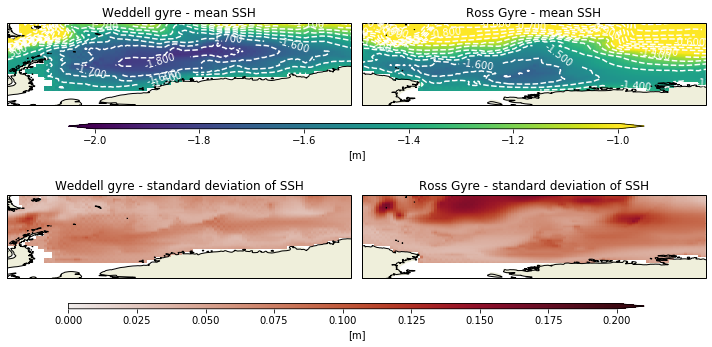

In [22]:
fignum = '08_34'

SSH = xr.open_mfdataset(datadir+'GODAS/ssh*', combine='by_coords').sshg.sel(lat=slice(-90, -50))

fig = plt.figure(figsize=(10, 5), constrained_layout=True)
gs = gridspec.GridSpec(4, 2, height_ratios=[6, 1, 6, 1]) 

for i in [0, 2]:
    for j, cl in enumerate([-7.5, 212.5]):
        projection = cartopy.crs.PlateCarree(central_longitude=cl)
        ai = fig.add_subplot(gs[i, j], projection=projection)

        ai.coastlines(resolution='50m')
        ai.add_feature(cartopy.feature.LAND)

        if j == 0:
            ai.set_extent([-70, 55, -80, -50], cartopy.crs.PlateCarree())
            reg = 'Weddell gyre'
        else:
            ai.set_extent([150, 360-85, -80, -50], cartopy.crs.PlateCarree())
            reg = 'Ross Gyre'

        if i == 0:
            var, cmap, vrange, extend = SSH.mean('time'), cm.viridis, [-2, -1], 'both'
            ai.set_title('%s - mean SSH' % reg)
        else:
            var, cmap, vrange, extend = SSH.std('time'), cmo.amp, [0, 0.2], 'max'
            ai.set_title('%s - standard deviation of SSH' % reg)
        a = ai.pcolormesh(cartopy.util.add_cyclic_point(SSH.lon), SSH.lat, cartopy.util.add_cyclic_point(var), 
                          cmap=cmap, vmin=vrange[0], vmax=vrange[1], transform=cartopy.crs.PlateCarree(), rasterized=True)
        if i == 0:
            CS = ai.contour(SSH.lon, SSH.lat, var, 
                            levels=np.arange(-2, 0, 0.1), colors='w', transform=cartopy.crs.PlateCarree())
            ai.clabel(CS, inline=1, fontsize=10)
    if i == 0:
        cbaxes = fig.add_axes([0.1, 0.6, 0.8, 0.015])
    else:
        cbaxes = fig.add_axes([0.1, 0.1, 0.8, 0.015])
    plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=50, extend=extend, label='[m]')

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

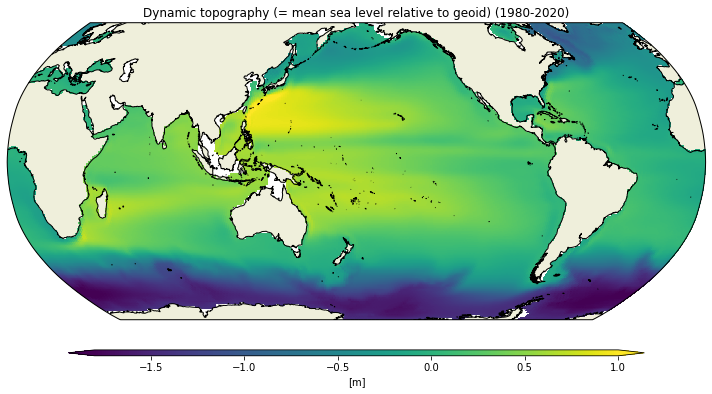

In [23]:
fignum = '10_02'

SSH = xr.open_mfdataset(datadir+'GODAS/ssh*', combine='by_coords').sshg.mean('time')

projection = cartopy.crs.Robinson(central_longitude=180)
fig = plt.figure(figsize=(10, 5.5), constrained_layout=True)
gs = gridspec.GridSpec(2, 1, height_ratios=[6, 1])
ax = fig.add_subplot(gs[0], projection=projection)
ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.LAND)

a = SSH.plot(cmap=cm.viridis, vmin=-1.8, vmax=1, add_colorbar=False, 
             transform=cartopy.crs.PlateCarree(), rasterized=True)

plt.title('Dynamic topography (= mean sea level relative to geoid) (1980-2020)')

cbaxes = fig.add_axes([0.1, 0.09, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='both', label='[m]', use_gridspec=True)

fig.canvas.draw()
plt.tight_layout()
savefig(fignum)

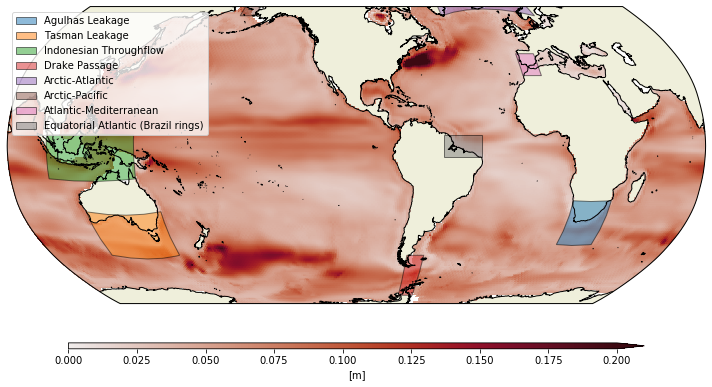

In [24]:
fignum = '10_03'

eke = xr.open_mfdataset(datadir+'GODAS/ssh*', combine='by_coords').sshg.std('time')

projection = cartopy.crs.Robinson(central_longitude=-100)
fig = plt.figure(figsize=(10, 5.5), constrained_layout=True)
gs = gridspec.GridSpec(2, 1, height_ratios=[6, 1])
ax = fig.add_subplot(gs[0], projection=projection)
ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.LAND)

a = eke.plot(cmap=cmo.amp, transform=cartopy.crs.PlateCarree(), add_colorbar=False,
             vmin=0, vmax=0.2, rasterized=True)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

recs = {'Agulhas Leakage': (15, -45, 20, 20, colors[0]),
        'Tasman Leakage': (115, -50, 40, 20, colors[1]),
        'Indonesian Throughflow': (100, -15, 45, 20, colors[2]),
        'Drake Passage': (-70, -70, 10, 20, colors[3]),
        'Arctic-Atlantic': (-45, 60, 60, 10, colors[4]),
        'Arctic-Pacific': (-175, 60, 10, 10, colors[5]),
        'Atlantic-Mediterranean': (-10, 32, 10, 10, colors[6]),
        'Equatorial Atlantic (Brazil rings)': (-55, -5, 20, 10, colors[7])
        }

for key, v in recs.items():
    ax.add_patch(mpatches.Rectangle(xy=[v[0], v[1]], width=v[2], height=v[3], label=key,
                                    facecolor=v[4], alpha=0.5, linewidth=1,
                                    edgecolor='k', transform=cartopy.crs.Geodetic()))

ax.legend()

cbaxes = fig.add_axes([0.1, 0.09, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='max', label='[m]', use_gridspec=True)

fig.canvas.draw()
plt.tight_layout()

savefig(fignum)

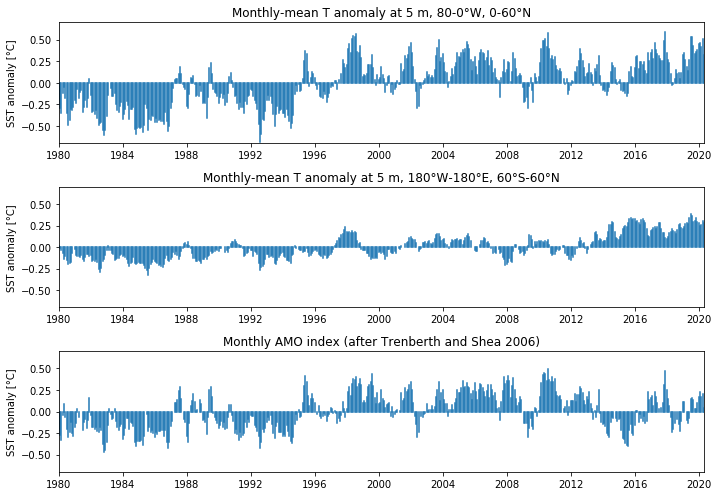

In [25]:
fignum = '11_24'
fig, ax = plt.subplots(3, 1, figsize=(10, 7))

T = xr.open_mfdataset(datadir+'GODAS/pottmp*', combine='by_coords')

temp = T.pottmp.isel(level=0).sel(lat=slice(0, 60), lon=slice(360-80, 360)).mean('lon').mean('lat')
climatology = temp.groupby("time.month").mean("time")
anomalies0 = temp.groupby("time.month") - climatology

ax[0].stem(temp.time, anomalies0, markerfmt=" ", basefmt=" ")
ax[0].set_ylabel('SST anomaly [%sC]'%degsym)
ax[0].set_xlim([temp.time[0].values, temp.time[-1].values])
ax[0].set_ylim([-0.7, 0.7])
ax[0].set_title('Monthly-mean T anomaly at %d m, 80-0%sW, 0-60%sN' % (temp.level.values, degsym, degsym))

temp = T.pottmp.isel(level=0).sel(lat=slice(-60, 60)).mean('lon').mean('lat')
climatology = temp.groupby("time.month").mean("time")
anomalies1 = temp.groupby("time.month") - climatology

ax[1].stem(temp.time, anomalies1, markerfmt=" ", basefmt=" ")
ax[1].set_ylabel('SST anomaly [%sC]'%degsym)
ax[1].set_xlim([temp.time[0].values, temp.time[-1].values])
ax[1].set_ylim([-0.7, 0.7])
ax[1].set_title('Monthly-mean T anomaly at %d m, 180%sW-180%sE, 60%sS-60%sN' % (temp.level.values, degsym, degsym, degsym, degsym))

ax[2].stem(temp.time, anomalies0-anomalies1, markerfmt=" ", basefmt=" ")
ax[2].set_ylabel('SST anomaly [%sC]'%degsym)
ax[2].set_xlim([temp.time[0].values, temp.time[-1].values])
ax[2].set_ylim([-0.7, 0.7])
ax[2].set_title('Monthly AMO index (after Trenberth and Shea 2006)')

plt.tight_layout()
savefig(fignum)

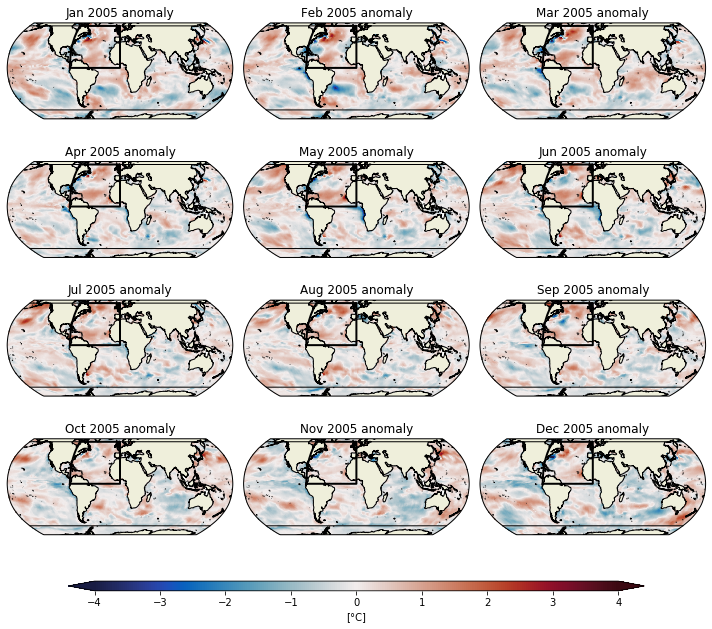

In [26]:
fignum = '11_25'

T = xr.open_mfdataset(datadir+'GODAS/pottmp*', combine='by_coords').pottmp.isel(level=0)
climatology = T.groupby("time.month").mean("time")
anomalies = T.groupby("time.month") - climatology

projection = cartopy.crs.Robinson(central_longitude=0)
fig = plt.figure(figsize=(10, 9), constrained_layout=True)
hr = 2
gs = gridspec.GridSpec(5, 3, height_ratios=[hr, hr, hr, hr, 1]) 

for col in range(3):
    for row in range(4):
        ai = fig.add_subplot(gs[row, col], projection=projection)
        i = col+row*3
        ai.coastlines(resolution='50m')
        ai.add_feature(cartopy.feature.LAND)
        temp = anomalies.sel(time='2005-%.2d-01' % (i+1))
        a = temp.plot(cmap=cmo.balance, vmin=-4, vmax=4,
                      transform=cartopy.crs.PlateCarree(), 
                      ax=ai, add_colorbar=False, rasterized=True)
        ai.plot([-80, 0, 0, -80, -80], [0, 0, 60, 60, 0], 'k', linewidth=2, transform=cartopy.crs.PlateCarree())
        ai.plot([-180, 180, 180, -180, -180], [-60, -60, 60, 60, -60], 'k', linewidth=1, transform=cartopy.crs.PlateCarree())
        ai.set_title('%s anomaly' % temp.time.dt.strftime('%b %Y').values)

cbaxes = fig.add_axes([0.1, 0.07, 0.8, 0.015])
plt.colorbar(a, cax=cbaxes, orientation="horizontal", aspect=100, extend='both', label='[%sC]' % degsym)
fig.canvas.draw()
plt.tight_layout()
savefig(fignum)